## Analysis fixation points vs heatmap points



In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import ast
from google.colab import drive
from PIL import Image
import math
import json
import random

drive.mount('/content/drive')

ValueError: mount failed

In [2]:
base_folder = '/content/drive/MyDrive/ucph/CCS3'

In [3]:
def calculate_fix_cross_coord(image, offset, screen_resolution = (1680,1050)):
    '''Calculate the fixation cross position relative to the image based on the display offset.'''
    start_x, start_y = offset[0], offset[1]
    center_x, center_y = screen_resolution[0] // 2, screen_resolution[1] // 2
    fix_cross_x = center_x - start_x  # Relative X position
    fix_cross_y = center_y - start_y  # Relative Y position
    return fix_cross_x, fix_cross_y


def plot_arrows_all_viewers(img, offset, fix_points_all_left, fix_points_all_right): # TO DO: handle nan values accordingly! And if there is a nan we should not draw an arrow?
    # Define colors for each viewer: bold color for left, pastel for right
    viewer_colors = [
        {'left': 'red', 'right': 'lightcoral'},
        {'left': 'blue', 'right': 'lightblue'},
        {'left': 'green', 'right': 'lightgreen'},
        {'left': 'purple', 'right': 'plum'},
        {'left': 'orange', 'right': 'peachpuff'}
    ]

    # Plot fixation points for all viewers
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title('Fixation Points per Viewer (Left and Right Eyes)')

    fix_cross_x, fix_cross_y = calculate_fix_cross_coord(img, offset)

    # Draw the fixation cross
    cross_size = 10
    cross_color = (1, 0, 0)
    plt.plot([fix_cross_x - cross_size, fix_cross_x + cross_size], [fix_cross_y, fix_cross_y], color=cross_color, lw=2)
    plt.plot([fix_cross_x, fix_cross_x], [fix_cross_y - cross_size, fix_cross_y + cross_size], color=cross_color, lw=2)

    # Plot fixation points for each viewer with distinct colors for each eye
    for viewer_id in range(1, 6):
        # Get fixation points for the current viewer for left and right eyes
        viewer_left_points = [point[1] for point in fix_points_all_left if point[0] == viewer_id][0] # fixation_points_all_left is a list of tuples for each viewer: [(1, [(x,y)])]
        viewer_right_points = [point[1] for point in fix_points_all_right if point[0] == viewer_id][0]

        if viewer_left_points:
            x_left = [point[0] for point in viewer_left_points]
            y_left = [point[1] for point in viewer_left_points]
            plt.scatter(x_left, y_left, color=viewer_colors[viewer_id - 1]['left'], label=f'Viewer {viewer_id} (Left)', s=70)

            # Draw arrows between consecutive points for the left eye
            for i in range(1, len(viewer_left_points)):
                x_start, y_start = viewer_left_points[i - 1]  # Unpacking tuple directly
                x_end, y_end = viewer_left_points[i]
                plt.arrow(x_start, y_start, x_end - x_start, y_end - y_start,
                          color=viewer_colors[viewer_id - 1]['left'], lw=2,
                          length_includes_head=True, head_width=5)

        # Plot right eye fixation points and draw arrows between points
        if viewer_right_points:
            x_right = [point[0] for point in viewer_right_points]
            y_right = [point[1] for point in viewer_right_points]
            plt.scatter(x_right, y_right, color=viewer_colors[viewer_id - 1]['right'], label=f'Viewer {viewer_id} (Right)', s=70)

            # Draw arrows between consecutive points for the right eye
            for i in range(1, len(viewer_right_points)):
                x_start, y_start = viewer_right_points[i - 1]  # Unpacking tuple directly
                x_end, y_end = viewer_right_points[i]
                plt.arrow(x_start, y_start, x_end - x_start, y_end - y_start,
                          color=viewer_colors[viewer_id - 1]['right'], lw=2,
                          length_includes_head=True, head_width=5)

    plt.legend()
    plt.show()


def plot_arrows_for_viewer(img, offset, fix_points_all_left, fix_points_all_right, duration_left, duration_right, viewer_id):
    '''Plots fixation points and arrows for a specific viewer (left and right eyes) and show longer durations of fixation points as larger circles.'''

    # Define colors for each viewer: bold color for left, pastel for right
    viewer_colors = [
        {'left': 'red', 'right': 'lightcoral'},
        {'left': 'blue', 'right': 'lightblue'},
        {'left': 'green', 'right': 'lightgreen'},
        {'left': 'purple', 'right': 'plum'},
        {'left': 'orange', 'right': 'peachpuff'}
    ]

    # Get durations

    viewer_left_durations = [duration for viewer, duration in duration_left if viewer == viewer_id][0]
    viewer_right_durations = [duration for viewer, duration in duration_right if viewer == viewer_id][0]

    # Get fixation points for the current viewer (left and right eyes)
    viewer_left_points = [point[1] for point in fix_points_all_left if point[0] == viewer_id][0] # fix_points_all_left is a list of tuples: [(viewer_id, [(x,y)])]
    viewer_right_points = [point[1] for point in fix_points_all_right if point[0] == viewer_id][0]

    # Plot fixation points for the specific viewer
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Fixation Points for Viewer {viewer_id} (Left and Right Eyes)')

    fix_cross_x, fix_cross_y = calculate_fix_cross_coord(img, offset)

    # Draw the fixation cross
    cross_size = 10
    cross_color = (1, 0, 0)
    plt.plot([fix_cross_x - cross_size, fix_cross_x + cross_size], [fix_cross_y, fix_cross_y], color=cross_color, lw=2)
    plt.plot([fix_cross_x, fix_cross_x], [fix_cross_y - cross_size, fix_cross_y + cross_size], color=cross_color, lw=2)

    # Plot left eye fixation points and draw arrows between points
    if viewer_left_points:
        x_left = [point[0] for point in viewer_left_points]
        y_left = [point[1] for point in viewer_left_points]

        # Map durations to circle sizes (scaling)
        min_size = 10  # Minimum circle size
        max_size = 100  # Maximum circle size
        sizes_left = np.interp(viewer_left_durations, (min(viewer_left_durations), max(viewer_left_durations)), (min_size, max_size)) # Scale fixation durations to circle sizes, mapping the duration range to the size range
        # Scatter plot with variable size based on duration
        plt.scatter(x_left, y_left, color=viewer_colors[viewer_id - 1]['left'], label=f'Viewer {viewer_id} (Left)', s=sizes_left)

        # Draw arrows between consecutive points for the left eye
        for i in range(1, len(viewer_left_points)):
            x_start, y_start = viewer_left_points[i - 1]  # Unpacking tuple directly
            x_end, y_end = viewer_left_points[i]
            plt.arrow(x_start, y_start, x_end - x_start, y_end - y_start,
                      color=viewer_colors[viewer_id - 1]['left'], lw=2,
                      length_includes_head=True, head_width=5)

    # Plot right eye fixation points and draw arrows between points
    if viewer_right_points:
        x_right = [point[0] for point in viewer_right_points]
        y_right = [point[1] for point in viewer_right_points]

        # Map durations to circle sizes (scaling)
        sizes_right = np.interp(viewer_right_durations, (min(viewer_right_durations), max(viewer_right_durations)), (min_size, max_size)) # Scale fixation durations to circle sizes, mapping the duration range to the size range

        # Scatter plot with variable size based on duration
        plt.scatter(x_right, y_right, color=viewer_colors[viewer_id - 1]['right'], label=f'Viewer {viewer_id} (Right)', s=sizes_right)

        # Draw arrows between consecutive points for the right eye
        for i in range(1, len(viewer_right_points)):
            x_start, y_start = viewer_right_points[i - 1]  # Unpacking tuple directly
            x_end, y_end = viewer_right_points[i]
            plt.arrow(x_start, y_start, x_end - x_start, y_end - y_start,
                      color=viewer_colors[viewer_id - 1]['right'], lw=2,
                      length_includes_head=True, head_width=5)

    plt.legend()
    plt.show()


def check_values(durations, points):
  new_duration = []
  new_points = []
  for duration, point in zip(durations, points):
    is_nan = math.isnan(duration) or math.isnan(point[0]) or math.isnan(point[1])
    is_neg = duration < 0 or point[0] < 0 or point[1] < 0
    if not is_nan and not is_neg:
      new_duration.append(duration)
      new_points.append(point)
  return new_duration, new_points


In [4]:
def get_fix_points(image_file_name, df):
    """
    Extract fixation points, durations, and offset for all viewers of a specific image.

    Parameters:
    - image_file_name (str): The name of the image file to filter (e.g., 'dog_2010_001366').
    - df (DataFrame): The full data frame containing eye-tracking data.

    Returns:
    - offset (list): The offset coordinates for the image.
    - fix_points_all_left (list of tuples): List of tuples (viewer_id, list of fixation points) for the left eye.
    - duration_left (list of tuples): List of tuples (viewer_id, list of durations) for the left eye.
    - fix_points_all_right (list of tuples): List of tuples (viewer_id, list of fixation points) for the right eye.
    - duration_right (list of tuples): List of tuples (viewer_id, list of durations) for the right eye.
    """
    #image_file_name = image_file_name.split('_', 1)[1]
    image_file_name = image_file_name.split('_', 1)[1].rsplit('.', 1)[0] # remove class prefix and the .jpg file extension

    image_data = df[df['image_file'] == image_file_name]
    offset = image_data['offset'].iloc[0]

    fix_points_all_left = []
    duration_left = []
    fix_points_all_right = []
    duration_right = []

    # Loop over each viewer's data for the image
    for _, row in image_data.iterrows():
        viewer_id = row['viewer']

        # Append (viewer_id, image_coordinates_left) to the left fixation points list
        fix_points_all_left.append((viewer_id, row['image_coordinates_left']))

        # Append (viewer_id, image_duration_left) to the left durations list
        duration_left.append((viewer_id, row['image_duration_left']))

        # Append (viewer_id, image_coordinates_right) to the right fixation points list
        fix_points_all_right.append((viewer_id, row['image_coordinates_right']))

        # Append (viewer_id, image_duration_right) to the right durations list
        duration_right.append((viewer_id, row['image_duration_right']))

    return offset, fix_points_all_left, duration_left, fix_points_all_right, duration_right


In [5]:
# INPUT_DIR = os.path.join(base_folder, "data_old")
INPUT_DIR = os.path.join(base_folder, "images")
file_path = os.path.join(base_folder, 'eye_tracking_data.pkl')
print(file_path)
et_df = pd.read_pickle(file_path)
et_df.head()
print(len(et_df))

/content/drive/MyDrive/ucph/CCS3/eye_tracking_data.pkl
31350


# some more stuff

In [ ]:
sample = et_df.iloc[0]
for column in et_df.columns:
    print(f"{column}: {type(sample[column])}: {sample[column]}")

class: <class 'str'>: diningtable
image_file: <class 'numpy.str_'>: 2010_001366
width_height: <class 'numpy.ndarray'>: [332 500]
offset: <class 'numpy.ndarray'>: [ 715  279 1215  611]
viewer: <class 'numpy.int64'>: 1
response: <class 'numpy.uint8'>: 1
image_coordinates_left: <class 'list'>: [(111.79999999999995, 256.79999999999995), (314.79999999999995, 224.8), (246.29999999999995, 167.7), (243.89999999999998, 196.39999999999998), (195.10000000000002, 226.5), (239.70000000000005, 223.60000000000002)]
image_start_end_time_left: <class 'list'>: [(7, 149), (186, 331), (359, 603), (618, 991), (1013, 1527), (1544, 1980)]
image_duration_left: <class 'list'>: [142, 145, 244, 373, 514, 436]
image_coordinates_right: <class 'list'>: [(100.79999999999995, 260.1), (304.70000000000005, 229.2), (232.89999999999998, 167.39999999999998), (230.79999999999995, 204.89999999999998), (198.60000000000002, 237.70000000000005), (244.70000000000005, 226.60000000000002)]
image_start_end_time_right: <class 'list

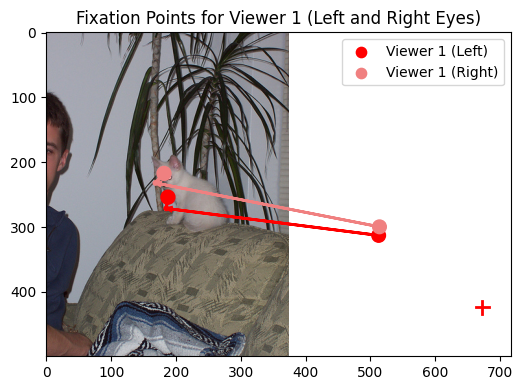

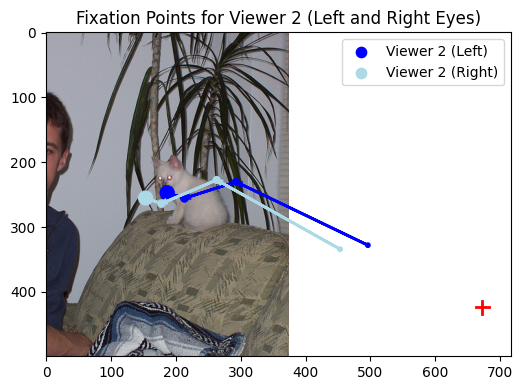

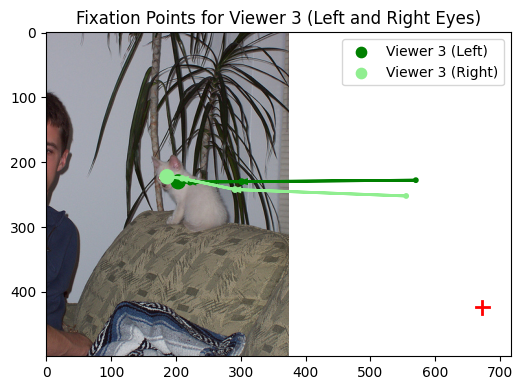

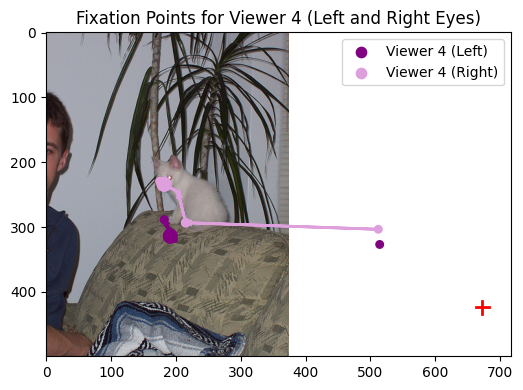

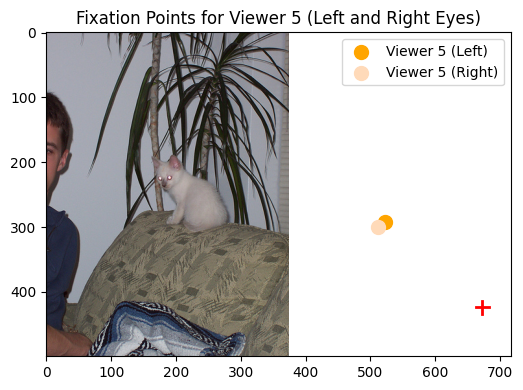

In [ ]:
#image_list = os.listdir(INPUT_DIR)
#random_image = np.random.choice(image_list)
filename = "cat_2010_002137.jpg"
image_path = os.path.join(INPUT_DIR, filename)

# Read and convert the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Get fixation points and duration for left and right eyes for the specific image
offset, fix_points_all_left, duration_left, fix_points_all_right, duration_right = get_fix_points(filename, et_df)

# Plot gaze patterns of all viewers
# plot_arrows_all_viewers(img, offset, fix_points_all_left, fix_points_all_right)

# Plot gaze patterns for each viewer with duration information
for viewer in range(1, 6):
  plot_arrows_for_viewer(img, offset, fix_points_all_left, fix_points_all_right, duration_left, duration_right, viewer)


# Find the best suited fixation points

## compare longest for both eyes with overall longest

In [ ]:
import math


def plot_best_fixation_points_per_viewer(img, offset, fix_points_all_left, fix_points_all_right, duration_left, duration_right):
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    for viewer_id in range(1, 6):
      axes[viewer_id-1].imshow(img)
      axes[viewer_id-1].grid(False)

      viewer_duration_left = duration_left[viewer_id - 1][1]
      viewer_duration_right = duration_right[viewer_id - 1][1]

      viewer_left_points = [point[1] for point in fix_points_all_left if point[0] == viewer_id][0]
      viewer_right_points = [point[1] for point in fix_points_all_right if point[0] == viewer_id][0]

      assert len(viewer_duration_left) == len(viewer_left_points)
      assert len(viewer_duration_right) == len(viewer_right_points)

      viewer_duration_left, viewer_left_points = check_values(viewer_duration_left, viewer_left_points)
      viewer_duration_right, viewer_right_points = check_values(viewer_duration_right, viewer_right_points)

      assert len(viewer_duration_left) == len(viewer_left_points)
      assert len(viewer_duration_right) == len(viewer_right_points)

      all_durations = viewer_duration_left + viewer_duration_right
      all_points = viewer_left_points + viewer_right_points

      duration_lists = [viewer_duration_left, viewer_duration_right, all_durations]
      fixation_points_list = [viewer_left_points, viewer_right_points, all_points]
      colors = ['red', 'blue', 'green']
      text = ['left', 'right', 'all']

      for i in range(3):
          duration = duration_lists[i]
          fixation_points = fixation_points_list[i]
          find_longest_duration(duration, fixation_points, axes[viewer_id-1], colors[i], text[i], viewer_id)

      axes[viewer_id-1].set_title(f'Viewer {viewer_id} {len(fixation_points)} fixations')

    plt.show()

def find_longest_duration(duration, fixation_points, ax, color, text, viewer_id):
    if len(duration) > 0:
      longest = np.argmax(duration)
      not_first_argmax = 0
      x = [point[0] for point in fixation_points]
      y = [point[1] for point in fixation_points]
      ax.scatter(x[longest], y[longest], color=color, label=f'longest {text}', s=70, marker='x')
      if len(duration[1:]) > 1:
        not_first_argmax = np.argmax(duration[1:]) + 1
        ax.scatter(x[not_first_argmax], y[not_first_argmax], color=color, label=f'not_first {text}', s=70, marker='*')


In [ ]:
image_list = os.listdir(INPUT_DIR)
for i in range(len(image_list)):
  random_image = np.random.choice(image_list)
  image_path = os.path.join(INPUT_DIR, random_image)
  # Read and convert the image
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print(random_image.split('_')[0])

  # Get fixation points and duration for left and right eyes for the specific image
  offset, fix_points_all_left, duration_left, fix_points_all_right, duration_right = get_fix_points(random_image, et_df)

  plot_best_fixation_points_per_viewer(img, offset, fix_points_all_left, fix_points_all_right, duration_left, duration_right)
  if i > 10:
    break


Output hidden; open in https://colab.research.google.com to view.

## Compare overall longest fixation point with threshold

4400


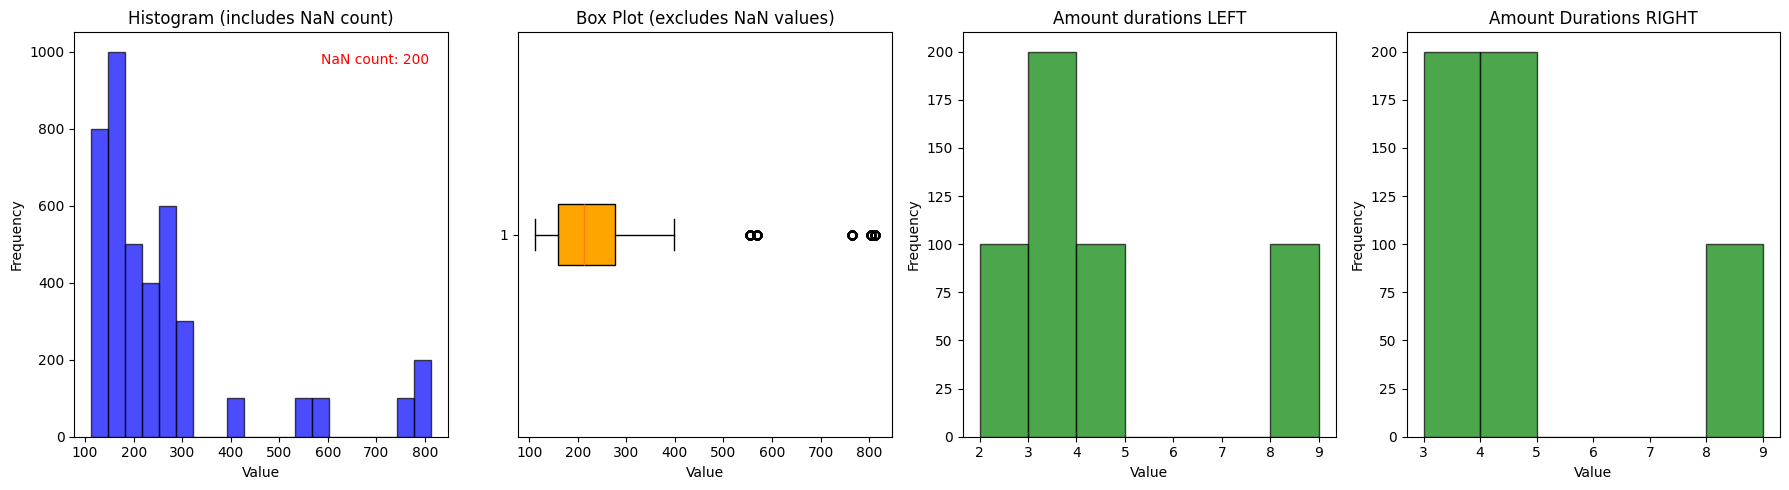

In [ ]:
# plot distribution of all fixation point durations

def plot_duration():
  image_list = os.listdir(INPUT_DIR)
  durations = []
  durations_length_left = []
  durations_length_right = []
  for filename in image_list:
    image_path = os.path.join(INPUT_DIR, filename)
    # Read and convert the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get fixation points and duration for left and right eyes for the specific image
    offset, fix_points_all_left, duration_left, fix_points_all_right, duration_right = get_fix_points(random_filename, et_df)
    for i in range(1,6):
      durations = durations + duration_left[i - 1][1]
      d_l = duration_left[i - 1][1]
      d_l = np.array(d_l)
      d_l = d_l[~np.isnan(d_l)]
      durations_length_left.append(d_l.shape[0])
      durations = durations + duration_right[i - 1][1]
      d_r = duration_right[i - 1][1]
      d_r = np.array(d_r)
      d_r = d_r[~np.isnan(d_r)]
      durations_length_right.append(d_r.shape[0])

  print(len(durations))
  # Create a figure and axes for the plots
  fig, axes = plt.subplots(1, 4, figsize=(18, 5))

  # Convert to a numpy array for easier handling of NaN
  values_array = np.array(durations)

  # Filter out NaN values for the box plot
  filtered_values = values_array[~np.isnan(values_array)]

  # Histogram (including NaN count)
  axes[0].hist(values_array, bins=20, color='blue', alpha=0.7, edgecolor='black')
  axes[0].set_title("Histogram (includes NaN count)")
  axes[0].set_xlabel("Value")
  axes[0].set_ylabel("Frequency")
  axes[0].text(
      0.95, 0.95, f"NaN count: {np.sum(np.isnan(values_array))}",
      transform=axes[0].transAxes, ha='right', va='top', fontsize=10, color='red'
  )

  # Box Plot (excluding NaN values)
  axes[1].boxplot(filtered_values, vert=False, patch_artist=True,
                  boxprops=dict(facecolor='orange', color='black'))
  axes[1].set_title("Box Plot (excludes NaN values)")
  axes[1].set_xlabel("Value")

  min_value = int(np.min(durations_length_left))
  max_value = int(np.max(durations_length_left))
  bins = range(min_value, max_value + 2)  # Ensure one bin per integer value
  axes[2].hist(durations_length_left, bins=bins, color='green', alpha=0.7, edgecolor='black')
  axes[2].set_title("Amount durations LEFT")
  axes[2].set_xlabel("Value")
  axes[2].set_ylabel("Frequency")

  min_value = int(np.min(durations_length_right))
  max_value = int(np.max(durations_length_right))
  bins = range(min_value, max_value + 2)  # Ensure one bin per integer value
  axes[3].hist(durations_length_right, bins=bins, color='green', alpha=0.7, edgecolor='black')
  axes[3].set_title("Amount Durations RIGHT")
  axes[3].set_xlabel("Value")
  axes[3].set_ylabel("Frequency")

  # Show the plots
  plt.tight_layout()
  plt.show()



plot_duration()


In [ ]:
def compare_longest_threshold_fixation_point(img, offset, fix_points_all_left, fix_points_all_right, duration_left, duration_right, show=True):
    points = []
    durations = []
    for viewer_id in range(1, 6):
      viewer_duration_left = duration_left[viewer_id - 1][1]
      viewer_duration_right = duration_right[viewer_id - 1][1]

      viewer_left_points = [point[1] for point in fix_points_all_left if point[0] == viewer_id][0]
      viewer_right_points = [point[1] for point in fix_points_all_right if point[0] == viewer_id][0]

      viewer_duration_left, viewer_left_points = check_values(viewer_duration_left, viewer_left_points)
      viewer_duration_right, viewer_right_points = check_values(viewer_duration_right, viewer_right_points)

      if not (len(viewer_duration_left) == len(viewer_left_points) and len(viewer_duration_right) == len(viewer_right_points)):
        return [], []

      all_durations = viewer_duration_left + viewer_duration_right
      all_points = viewer_left_points + viewer_right_points

      colors = ['red', 'blue', 'green', 'yellow', 'pink']
      point, duration = find_longest_duration(all_durations, all_points)
      if show:
        plt.scatter(point[0], point[1], color=colors[viewer_id-1], label=f'{viewer_id}', s=70, marker='x')

      colors = ['red', 'blue', 'green', 'yellow', 'pink']
      point, duration = find_thresholded(all_durations, all_points)
      if show:
        plt.scatter(point[0], point[1], color=colors[viewer_id-1], label=f'{viewer_id}', s=70, marker='*')

    if show:
      plt.imshow(img)
      plt.grid(False)
      plt.show()
    return points, durations

def find_thresholded(duration, fixation_points):
    longest = np.argmax(duration)
    if duration[longest] > 500 and len(duration) > 1:
      print(f"Longest duration too long: {duration[longest]}")
      duration.remove(duration[longest])
      fixation_points.remove(fixation_points[longest])
      longest = np.argmax(duration)
    x = [point[0] for point in fixation_points]
    y = [point[1] for point in fixation_points]
    point = (x[longest], y[longest])
    return point, duration[longest]

def find_longest_duration(duration, fixation_points):
    longest = np.argmax(duration)
    x = [point[0] for point in fixation_points]
    y = [point[1] for point in fixation_points]
    point = (x[longest], y[longest])
    return point, duration[longest]

In [ ]:
image_list = os.listdir(INPUT_DIR)
for i in range(len(image_list)):
  random_image = np.random.choice(image_list)
  image_path = os.path.join(INPUT_DIR, random_image)
  # Read and convert the image
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print(random_image.split('_')[0])

  # Get fixation points and duration for left and right eyes for the specific image
  offset, fix_points_all_left, duration_left, fix_points_all_right, duration_right = get_fix_points(random_image, et_df)

  compare_longest_threshold_fixation_point(img, offset, fix_points_all_left, fix_points_all_right, duration_left, duration_right)
  if i > 10:
    break

Output hidden; open in https://colab.research.google.com to view.

# Create Dict with best fixation point per viewer and image using longest fixation


In [8]:
def check_values(durations, points):
  new_duration = []
  new_points = []
  for duration, point in zip(durations, points):
    is_nan = math.isnan(duration) or math.isnan(point[0]) or math.isnan(point[1])
    is_neg = duration < 0 or point[0] < 0 or point[1] < 0
    if not is_nan and not is_neg:
      new_duration.append(duration)
      new_points.append(point)
  return new_duration, new_points

def find_best_fixation_points_per_img(img, offset, fix_points_all_left, fix_points_all_right, duration_left, duration_right, show=False):
    points = []
    durations = []
    for viewer_id in range(1, 6):
      viewer_duration_left = duration_left[viewer_id - 1][1]
      viewer_duration_right = duration_right[viewer_id - 1][1]

      viewer_left_points = [point[1] for point in fix_points_all_left if point[0] == viewer_id][0]
      viewer_right_points = [point[1] for point in fix_points_all_right if point[0] == viewer_id][0]

      viewer_duration_left, viewer_left_points = check_values(viewer_duration_left, viewer_left_points)
      viewer_duration_right, viewer_right_points = check_values(viewer_duration_right, viewer_right_points)

      # Ensure lengths match
      if not (len(viewer_duration_left) == len(viewer_left_points) and len(viewer_duration_right) == len(viewer_right_points)):
        points.append([])
        durations.append(0)
        continue

      # Combine durations and points
      all_durations = viewer_duration_left + viewer_duration_right
      all_points = viewer_left_points + viewer_right_points

      img_height, img_width = img.shape[:2]
      # **Filter out points outside the image boundaries**
      valid_points_and_durations = [
          (point, duration)
          for point, duration in zip(all_points, all_durations)
          if 0 <= point[1] < img_height and 0 <= point[0] < img_width
      ]

      # If no valid points remain, skip this viewer
      if not valid_points_and_durations:
        points.append([])
        durations.append(0)
        continue

      # Unpack the valid points and durations
      all_points, all_durations = zip(*valid_points_and_durations)

      if not (len(all_points) == len(all_durations)):
        points.append([])
        durations.append(0)
        continue

      all_durations = viewer_duration_left + viewer_duration_right
      all_points = viewer_left_points + viewer_right_points

      colors = ['red', 'blue', 'green', 'yellow', 'pink']
      point, duration = find_longest_duration(all_durations, all_points)
      points.append(point)
      durations.append(duration)
      if show:
        plt.scatter(point[0], point[1], color=colors[viewer_id-1], label=f'{viewer_id}', s=70, marker='x')
    if show:
      plt.imshow(img)
      plt.grid(False)
      plt.show()
    assert len(points) == len(durations) == 5
    return points, durations

def find_longest_duration(duration, fixation_points):
    if len(duration) > 0:
      longest = np.argmax(duration)
      x = [point[0] for point in fixation_points]
      y = [point[1] for point in fixation_points]
      point = (x[longest], y[longest])
      return point, duration[longest]
    else:
      return [], 0


In [9]:
import json

image_list = os.listdir(INPUT_DIR)
fixation_points_dict = {}
filenames_without_fix_points = []
for i in range(len(image_list)):
  filename = image_list[i]
  image_path = os.path.join(INPUT_DIR, filename)
  # Read and convert the image
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get fixation points and duration for left and right eyes for the specific image
  offset, fix_points_all_left, duration_left, fix_points_all_right, duration_right = get_fix_points(filename, et_df)

  img_points, img_durations = find_best_fixation_points_per_img(img, offset, fix_points_all_left, fix_points_all_right, duration_left, duration_right)
  if len(img_points) == 0:
    print(f"No valid points found for: {filename}")
    fixation_points_dict[filename] = ([[], [], [], [], []], [0, 0, 0, 0, 0])
  else:
    img_points = list([[int(round(value)) for value in point] for point in img_points])
    fixation_points_dict[filename] = (img_points, img_durations)

def convert_for_json(obj):
    if isinstance(obj, (np.ndarray, list)):
        return [convert_for_json(x) for x in obj]
    elif isinstance(obj, (np.integer, np.uint16, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    else:
        return obj



In [10]:
# ensure for each image we obtain exactly 5 fixation points to not loose information about the viewer.
# this way we also count missing fixation points as not included in the segmentation mask as expected.

for key, value in fixation_points_dict.items():
  if not (len(value[0]) == 5 and len(value[1]) == 5):
    print(f"Problem: {key}, {value}")

In [11]:
with open(os.path.join(base_folder, 'point_dict_fixation.json'), "w") as file:
    json.dump(fixation_points_dict, file, indent=4, default=convert_for_json)


In [12]:
import random

# Path to the JSON file
file_path = os.path.join(base_folder, 'point_dict_fixation.json')

# Read the dictionary from the JSON file
with open(file_path, "r") as file:
    fixation_points_dict = json.load(file)

# Get a random sample
random_key = random.choice(list(fixation_points_dict.keys()))  # Pick a random key
random_sample = fixation_points_dict[random_key]

# Output the random sample
print(f"Random Key: {type(random_key)} {random_key}")
print(f"Random Sample: {type(random_sample)} {random_sample}")
print(len(os.listdir(INPUT_DIR)))
print(len(list(set(os.listdir(INPUT_DIR)))))

print(len(fixation_points_dict.keys()))

Random Key: <class 'str'> motorbike_2011_000512.jpg
Random Sample: <class 'list'> [[[274, 182], [220, 168], [325, 245], [237, 199], [276, 218]], [317, 746, 374, 448, 411]]
1220
1220
1220
